In [1]:
!pip install youtube-dl==2020.12.2
!pip install pafy
!pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import pafy
from pytube import YouTube
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
 
from moviepy.editor import *
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
#doing this to get the consistent result
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
%%capture
 
# Downlaoding the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
 
#Extract the Dataset
!unrar x UCF50.rar

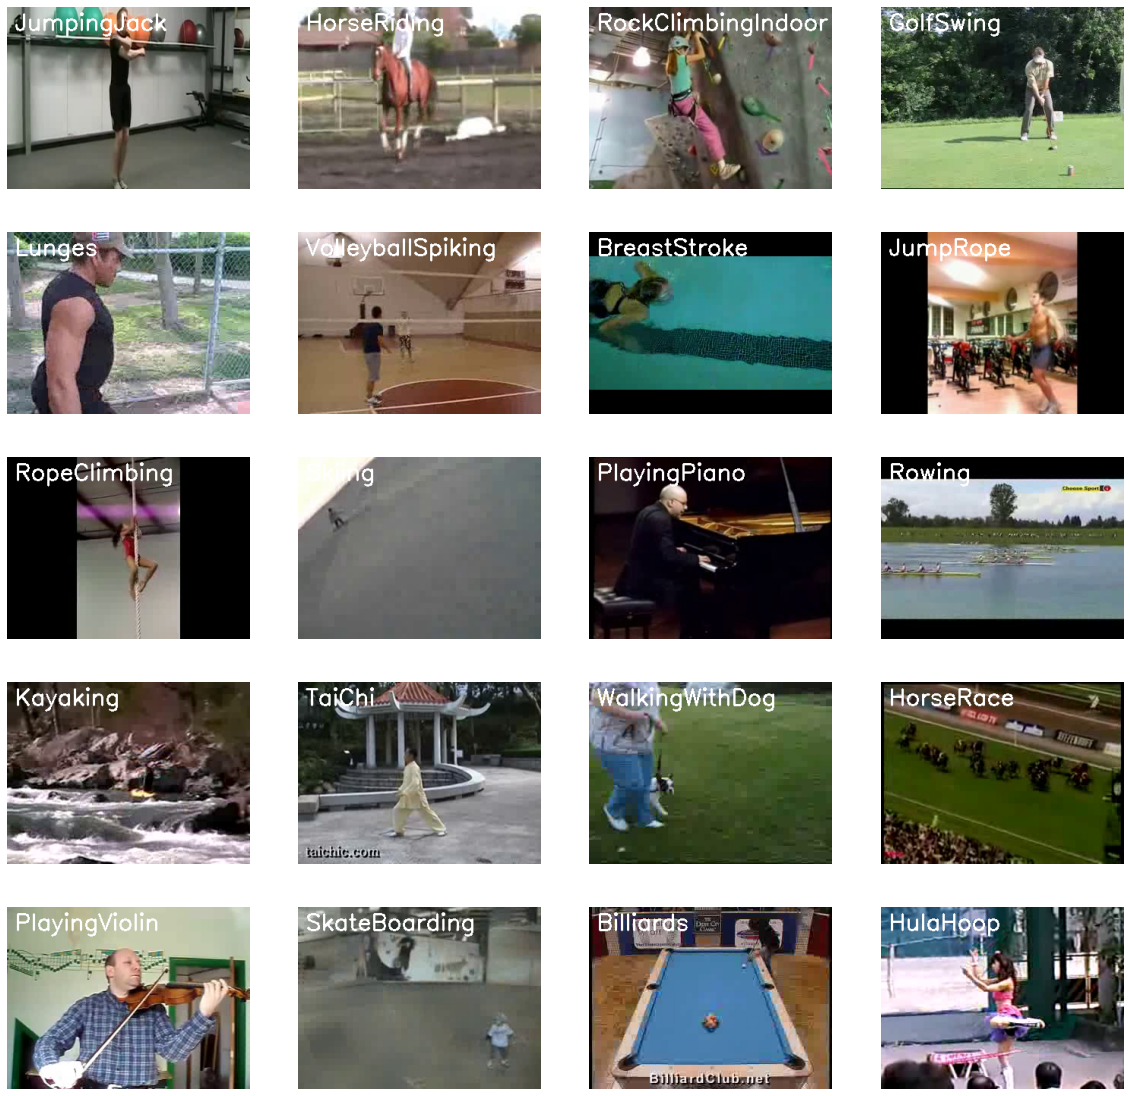

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))
 
# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')
 
# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 20)
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
# Specifying the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
DATASET_DIR = "UCF50"
# Specifying the list containing the names of the classes used for training 
CLASSES_LIST = ["TaiChi","WalkingWithDog", "Swing", "HorseRace"]

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
    
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Return the frames list.
    return frames_list

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
 
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Displaying the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: TaiChi
Extracting Data of Class: WalkingWithDog
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [ ]:
# converting labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [ ]:

def create_LRCN_model():
    '''
    This function will construct the required LRCN (CNN + LSTM) model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
 
    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Defining the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
    #adding the dense layer                                  
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax')) 
 
    ########################################################################################################################
 
    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()
 
# Display the success message.
print("Model Created Successfully!")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeDi  (None, 20, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 20, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 20, 4, 4, 32)    

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
73/73 [==============================] - 16s 189ms/step - loss: 1.3510 - accuracy: 0.3630 - val_loss: 1.2568 - val_accuracy: 0.4521
Epoch 2/70
73/73 [==============================] - 13s 177ms/step - loss: 1.3204 - accuracy: 0.3836 - val_loss: 1.6680 - val_accuracy: 0.2466
Epoch 3/70
73/73 [==============================] - 13s 176ms/step - loss: 1.2801 - accuracy: 0.4212 - val_loss: 1.2685 - val_accuracy: 0.3562
Epoch 4/70
73/73 [==============================] - 13s 178ms/step - loss: 1.1565 - accuracy: 0.5103 - val_loss: 1.3561 - val_accuracy: 0.3836
Epoch 5/70
73/73 [==============================] - 13s 177ms/step - loss: 0.9825 - accuracy: 0.5788 - val_loss: 0.9004 - val_accuracy: 0.6164
Epoch 6/70
73/73 [==============================] - 13s 178ms/step - loss: 0.9255 - accuracy: 0.5856 - val_loss: 1.1003 - val_accuracy: 0.6164
Epoch 7/70
73/73 [==============================] - 13s 178ms/step - loss: 0.8372 - accuracy: 0.6678 - val_loss: 0.8142 - val_accuracy: 0.6849
Epoch 8/70
73/73 [==============================] - 13s 177ms/step - loss: 0.8419 - accuracy: 0.6747 - val_loss: 0.9070 - val_accuracy: 0.5890
Epoch 9/70
73/73 [==============================] - 13s 176ms/step - loss: 0.7378 - accuracy: 0.7192 - val_loss: 0.6669 - val_accuracy: 0.7260
Epoch 10/70
73/73 [==============================] - 13s 177ms/step - loss: 0.7151 - accuracy: 0.6986 - val_loss: 1.0156 - val_accuracy: 0.6438
Epoch 11/70
73/73 [==============================] - 13s 176ms/step - loss: 0.5930 - accuracy: 0.7671 - val_loss: 0.6352 - val_accuracy: 0.7397
Epoch 12/70
73/73 [==============================] - 13s 176ms/step - loss: 0.5492 - accuracy: 0.7979 - val_loss: 1.0242 - val_accuracy: 0.6301
Epoch 13/70
73/73 [==============================] - 13s 176ms/step - loss: 0.5063 - accuracy: 0.7979 - val_loss: 0.4644 - val_accuracy: 0.8630
Epoch 14/70
73/73 [==============================] - 13s 175ms/step - loss: 0.4290 - accuracy: 0.8459 - val_loss: 0.6569 - val_accuracy: 0.7397
Epoch 15/70
73/73 [==============================] - 13s 176ms/step - loss: 0.3858 - accuracy: 0.8870 - val_loss: 0.6952 - val_accuracy: 0.7397
Epoch 16/70
73/73 [==============================] - 13s 175ms/step - loss: 0.3802 - accuracy: 0.8596 - val_loss: 0.4299 - val_accuracy: 0.8493
Epoch 17/70
73/73 [==============================] - 13s 176ms/step - loss: 0.2815 - accuracy: 0.9110 - val_loss: 0.4349 - val_accuracy: 0.8630
Epoch 18/70
73/73 [==============================] - 13s 175ms/step - loss: 0.3104 - accuracy: 0.9041 - val_loss: 0.5529 - val_accuracy: 0.7808
Epoch 19/70
73/73 [==============================] - 13s 175ms/step - loss: 0.3778 - accuracy: 0.8664 - val_loss: 0.3810 - val_accuracy: 0.8904
Epoch 20/70
73/73 [==============================] - 13s 176ms/step - loss: 0.2260 - accuracy: 0.9178 - val_loss: 0.3428 - val_accuracy: 0.8630
Epoch 21/70
73/73 [==============================] - 13s 176ms/step - loss: 0.2346 - accuracy: 0.9281 - val_loss: 0.3948 - val_accuracy: 0.8767
Epoch 22/70
73/73 [==============================] - 13s 176ms/step - loss: 0.2286 - accuracy: 0.9075 - val_loss: 0.3509 - val_accuracy: 0.9041
Epoch 23/70
73/73 [==============================] - 14s 191ms/step - loss: 0.1974 - accuracy: 0.9349 - val_loss: 0.4423 - val_accuracy: 0.8082
Epoch 24/70
73/73 [==============================] - 13s 175ms/step - loss: 0.2370 - accuracy: 0.9075 - val_loss: 0.5953 - val_accuracy: 0.7808
Epoch 25/70
73/73 [==============================] - 13s 176ms/step - loss: 0.2501 - accuracy: 0.9075 - val_loss: 0.3794 - val_accuracy: 0.8904
Epoch 26/70
73/73 [==============================] - 13s 176ms/step - loss: 0.1331 - accuracy: 0.9555 - val_loss: 0.4019 - val_accuracy: 0.8767
Epoch 27/70
73/73 [==============================] - 13s 176ms/step - loss: 0.1124 - accuracy: 0.9623 - val_loss: 0.4253 - val_accuracy: 0.8904
Epoch 28/70
73/73 [==============================] - 13s 175ms/step - loss: 0.1295 - accuracy: 0.9555 - val_loss: 0.5010 - val_accuracy: 0.8356
Epoch 29/70
73/73 [==============================] - 13s 175ms/step - loss: 0.1163 - accuracy: 0.9726 - val_loss: 0.3778 - val_accuracy: 0.9041
Epoch 30/70
73/73 [==============================] - 13s 174ms/step - loss: 0.1016 - accuracy: 0.9692 - val_loss: 0.6681 - val_accuracy: 0.8356
Epoch 31/70
73/73 [==============================] - 13s 178ms/step - loss: 0.1926 - accuracy: 0.9281 - val_loss: 0.4096 - val_accuracy: 0.8630
Epoch 32/70
73/73 [==============================] - 13s 174ms/step - loss: 0.0867 - accuracy: 0.9692 - val_loss: 0.4511 - val_accuracy: 0.8630
Epoch 33/70
73/73 [==============================] - 13s 174ms/step - loss: 0.0693 - accuracy: 0.9795 - val_loss: 0.3202 - val_accuracy: 0.9041
Epoch 34/70
73/73 [==============================] - 13s 175ms/step - loss: 0.0295 - accuracy: 0.9932 - val_loss: 0.4592 - val_accuracy: 0.8904
Epoch 35/70
73/73 [==============================] - 13s 175ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.5841 - val_accuracy: 0.8219
Epoch 36/70
73/73 [==============================] - 13s 175ms/step - loss: 0.1658 - accuracy: 0.9418 - val_loss: 0.3164 - val_accuracy: 0.9178
Epoch 37/70
73/73 [==============================] - 13s 175ms/step - loss: 0.0341 - accuracy: 0.9966 - val_loss: 0.3369 - val_accuracy: 0.9178
Epoch 38/70
73/73 [==============================] - 13s 175ms/step - loss: 0.0386 - accuracy: 0.9897 - val_loss: 0.6094 - val_accuracy: 0.8493
Epoch 39/70
73/73 [==============================] - 13s 175ms/step - loss: 0.0511 - accuracy: 0.9795 - val_loss: 0.3337 - val_accuracy: 0.9178
Epoch 40/70
73/73 [==============================] - 13s 175ms/step - loss: 0.1536 - accuracy: 0.9521 - val_loss: 0.7839 - val_accuracy: 0.7123
Epoch 41/70
73/73 [==============================] - 13s 175ms/step - loss: 0.1394 - accuracy: 0.9623 - val_loss: 0.2815 - val_accuracy: 0.9315
Epoch 42/70
73/73 [==============================] - 13s 175ms/step - loss: 0.1234 - accuracy: 0.9521 - val_loss: 0.5001 - val_accuracy: 0.8219
Epoch 43/70
73/73 [==============================] - 13s 176ms/step - loss: 0.0290 - accuracy: 0.9932 - val_loss: 0.4845 - val_accuracy: 0.8767
Epoch 44/70
73/73 [==============================] - 13s 176ms/step - loss: 0.1832 - accuracy: 0.9247 - val_loss: 0.4567 - val_accuracy: 0.8630
Epoch 45/70
73/73 [==============================] - 13s 175ms/step - loss: 0.1172 - accuracy: 0.9589 - val_loss: 0.5545 - val_accuracy: 0.8767
Epoch 46/70
73/73 [==============================] - 13s 176ms/step - loss: 0.1374 - accuracy: 0.9521 - val_loss: 0.5360 - val_accuracy: 0.8630
Epoch 47/70
73/73 [==============================] - 13s 175ms/step - loss: 0.0217 - accuracy: 1.0000 - val_loss: 0.3548 - val_accuracy: 0.9041
Epoch 48/70
73/73 [==============================] - 14s 191ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.3685 - val_accuracy: 0.9041
Epoch 49/70
73/73 [==============================] - 13s 175ms/step - loss: 0.0210 - accuracy: 0.9966 - val_loss: 0.3951 - val_accuracy: 0.9041
Epoch 50/70
73/73 [==============================] - 13s 175ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.4032 - val_accuracy: 0.9178
Epoch 51/70
73/73 [==============================] - 13s 176ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.3983 - val_accuracy: 0.9178
Epoch 52/70
73/73 [==============================] - 13s 176ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.4127 - val_accuracy: 0.9178
Epoch 53/70
73/73 [==============================] - 13s 176ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4147 - val_accuracy: 0.9178
Epoch 54/70
73/73 [==============================] - 13s 176ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.4053 - val_accuracy: 0.9315
Epoch 55/70
73/73 [==============================] - 13s 176ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.4086 - val_accuracy: 0.9415
Epoch 56/70
73/73 [==============================] - 13s 176ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.4133 - val_accuracy: 0.9615

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 2s 411ms/step - loss: 0.4475 - accuracy: 0.9369

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save the Model.
LRCN_model.save(model_file_name)

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
   
     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)
 
     # Retrieve the title of the video.
     title = video.title
 
     # Get the best available quality object for the video.
     video_best = video.getbest()
 
     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'
 
     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)
 
     # Return the video title.
     return title

In [ ]:

test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)
 
# Downloading a YouTube Video.
video_title = download_youtube_videos('https://youtu.be/8u0qjmHIOcE', test_videos_directory)
 
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
 
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
 
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
 
        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
 
        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)
 
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:
 
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
 
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]
 
        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
 
        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
 
# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
 
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|██████████| 867/867 [00:02<00:00, 343.47it/s]


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
   
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

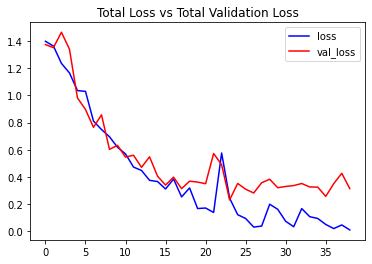

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')